# Connectivity Classifier

Steps:
1. Load the data
2. Fit a SVM + HPO
3. Permutation testing
4. Permutation Importance
5. SHAP

## Inputs

Connectivity matrices

## Outputs

Participant's label, either AVGP or NVGP.

## Requirements

To run this notebook, you need to have the rapids packages installed:

```bash
mamba create -n rapids-22.04 \
    -c rapidsai -c nvidia -y \
    rapids=22.04 python=3.9 cudatoolkit=11.5 \
    jupyterlab ipykernel nilearn xarray netcdf4 seaborn shap

mamba activate rapids-22.04

pip install statannotations -U

# [Optional] Bayesian HBO
# pip install "ray[tune]" tune-sklearn scikit-optimize
```


## Analysis

In [2]:
# SETUP

%reload_ext autoreload
%autoreload 3

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from ray import tune
from ray.tune.sklearn import TuneSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC

try:
    from cuml import PCA, SVC, UMAP
    from cuml.model_selection import GridSearchCV
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
except ImportError as e:
    print('cuML not installed. Skipping GPU and falling back to scikit.')



cuML not installed. Skipping GPU and falling back to scikit.


In [3]:
# 0. PARAMETERS

#  WARNING: Ray Tune requires data paths to be absolute.
BIDS_DIR = Path.home() / 'workspace/acnets/data/julia2018'
CACHE_DIR = Path.home() / 'workspace/acnets/data/julia2018_resting'

In [4]:
# 1. DATA

subjects = ConnectivityPipeline().transform('all').coords['subject'].values
groups = [s[:4] for s in subjects]  # AVGP or NVGP

X = subjects.reshape(-1, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(groups)

In [20]:
# 2. MODELING PIPELINE

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline(bids_dir=BIDS_DIR, parcellation_cache_dir=CACHE_DIR)),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    ('select', SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=10000))),
    # ('reduce', PCA()),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=10000))
    # ('clf', RandomForestClassifier())
])

# DEBUG
# pipe.fit(X, y).score(X, y)

# DEBUG: test some good defaults
pipe.set_params(connectivity__atlas='dosenbach2010', connectivity__kind='partial correlation')

scores = cross_val_score(pipe, X, y,
                         cv=StratifiedShuffleSplit(n_splits=1000, test_size=8),
                         scoring='accuracy',
                         n_jobs=-1)
bootstrap_ci = st.bootstrap(scores.reshape(1,-1), np.mean)
scores.mean(), scores.std(), bootstrap_ci

(0.713375,
 0.14995577473041843,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.70375, high=0.722625), standard_error=0.004815045711873505))

In [21]:
# HPO: Bayesian Optimization

%%script echo skipping bayesian optimization...



param_space = {
    # 'scale': tune.choice([StandardScaler(), 'passthrough']),
    # 'select': tune.choice([SelectFromModel(LinearSVC(penalty='l2')), 'passthrough']),
    'clf__C': tune.loguniform(1e-2, 1e3),
    'connectivity__atlas': tune.choice(['dosenbach2010']),#, 'gordon2014_2mm', 'difumo_64_2mm', 'seitzman2018'],
    'connectivity__kind': tune.choice(['partial correlation', 'chatterjee', 'correlation', 'tangent']),
}

opt = TuneSearchCV(
    pipe,
    param_space,
    cv=4,
    n_trials=10,
    # early_stopping=True,
    max_iters=2,
    search_optimization='bayesian',
    verbose=1,
    scoring='accuracy',
    use_gpu=True,
    n_jobs=-1)

opt.fit(X, y)

print('best estimator:', opt.best_estimator_)


skipping bayesian optimization...


In [35]:
# HPO: Grid Search

param_grid = {
    'connectivity__atlas': ['gordon2014_2mm', 'dosenbach2010', 'difumo_64_2mm'],
    # 'connectivity__atlas': ['seitzman2018'],
    'connectivity__kind': ['partial correlation', 'tangent', 'correlation', 'covariance', 'precision'],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=StratifiedShuffleSplit(n_splits=100, test_size=8),
    verbose=2,
    scoring='accuracy')

grid.fit(X, y)

print('best estimator:', grid.best_estimator_)


Fitting 100 folds for each of 15 candidates, totalling 1500 fits
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.4s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.3s
[CV] END connectivity__atlas=gordon2014_2mm, connectivity__kind=partial correlation; total time=   0.4s

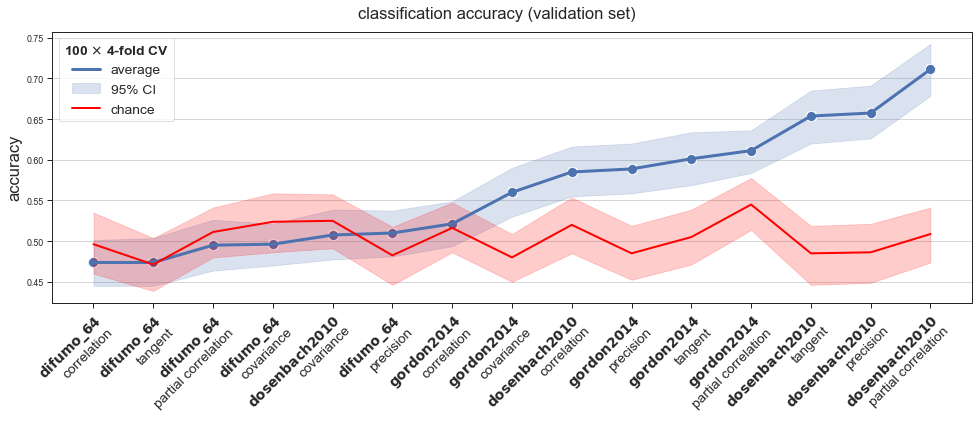

In [42]:
# PLOT MODEL PERFORMANCE

def _create_label(params):
    return f'$\\bf{{{params[0]}}}$\n{params[1]}'.replace('_2mm', '').replace('_','\\_')


def plot_scores(grid, X=None, y=None, plot_chance=True, n_subjects=32):

    # prep data
    scores = pd.DataFrame(grid.cv_results_)
    scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
    split_score_cols = [c for c in scores.columns if 'split' in c]
    scores['cv_test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
    scores = scores.explode('cv_test_score').reset_index(drop=True)
    scores = scores.sort_values('rank_test_score', ascending=False)

    _, ax = plt.subplots(figsize=(len(grid.cv_results_['params']) * 1.1, 5))

    # score curve + CI
    sns.lineplot(data=scores, x='label', y='cv_test_score', lw=3, sort=False, ax=ax)

    # blue dots
    sns.scatterplot(data=scores, x='label', y='mean_test_score', marker='o', s=100, ax=ax, label='_nolegend_')

    if plot_chance:
        # simulate chance
        chance_scores = {}
        for model_name in scores['label'].unique():
            chance_model = DummyClassifier(strategy='stratified').fit(X, y)
            _chance_scores = cross_val_score(chance_model, X, y, cv=grid.cv, scoring=grid.scoring)
            chance_scores[model_name] = _chance_scores

        chance_scores = pd.DataFrame(chance_scores)
        chance_scores = chance_scores.melt(value_name=grid.scoring, var_name='label')

        # plot chance
        sns.lineplot(data=chance_scores, x='label', y=grid.scoring, lw=2, sort=False, ax=ax, color='red')

    # legend
    ax.legend(['average', '95% CI', 'chance'],
                title_fontproperties={'weight': 'bold', 'size': 'x-large'},
                prop={'size': 'x-large'}, loc='upper left',
                title=f'{grid.cv.n_splits} $\\times$ {n_subjects // grid.cv.test_size}-fold CV')

    # tweaks
    ax.set_xlabel('')
    ax.set_ylabel(grid.scoring, fontsize='xx-large')
    plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
    plt.suptitle(f'classification {grid.scoring} (validation set)', fontsize='xx-large', y=.95)
    plt.grid(axis='y')

sns.set('paper', 'ticks')
plot_scores(grid, X, y)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$\bf{chance}$ vs. dosenbach2010 partial correlation: t-test independent samples, P_val:1.663e-16 t=-9.018e+00


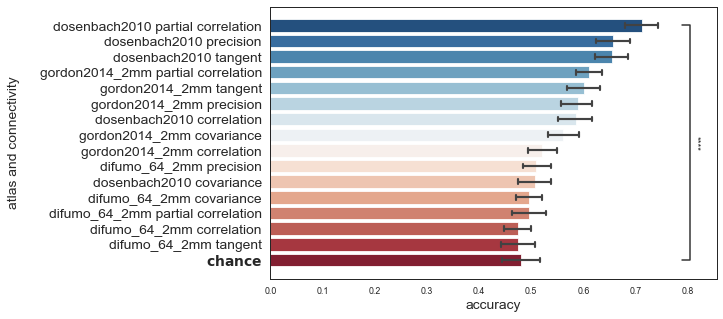

In [135]:
# SIGNIFICANCE TESTING

scores = pd.DataFrame(grid.cv_results_)
scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['cv_test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('cv_test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

chance_model = DummyClassifier(strategy='stratified')
chance_scores = cross_val_score(chance_model, X, y, cv=grid.cv, scoring=grid.scoring)

# visible_labels = ['chance','dosenbach2010 tangent', 'dosenbach2010 precision', 'dosenbach2010'
#        'dosenbach2010 partial correlation']

# scores = scores.query('label in @visible_labels')


scores = pd.concat([pd.DataFrame({
    'cv_test_score': chance_scores,
    'label': '$\\bf{chance}$'
}), scores]).reset_index()

_, ax = plt.subplots(figsize=(8, 5))


sns.set('paper', style='white')
g = sns.barplot(data=scores[::-1], y='label', x='cv_test_score', orient='h', ci=95, capsize=.3, ax=ax, palette='RdBu_r')
ax.set_xlabel(grid.scoring, fontsize='x-large')
ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large')

ax.set_ylabel('atlas and connectivity', fontsize='x-large', labelpad=20)


from statannotations.Annotator import Annotator

annotator = Annotator(g, [("dosenbach2010 partial correlation", '$\\bf{chance}$')], data=scores, y='label', x='cv_test_score', orient='h')
annotator.configure(test='t-test_ind', text_format='star', loc='inside',)
annotator.apply_and_annotate()


plt.show()


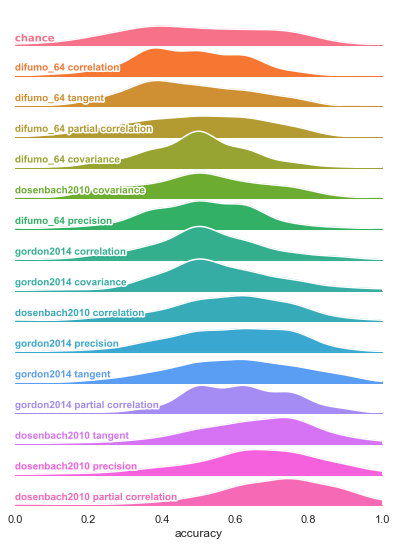

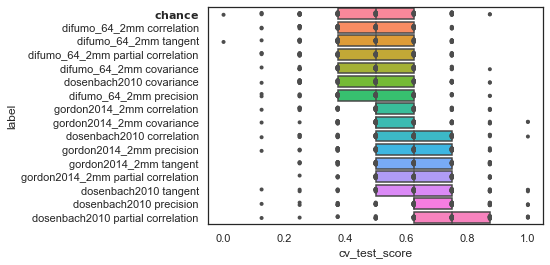

In [44]:
# PLOTS
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(scores, row="label", hue="label", aspect=12, height=.5)

# Draw the densities in a few steps
g.map(sns.kdeplot, "cv_test_score",fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "cv_test_score", color="w", lw=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

import matplotlib.patheffects as PathEffects

def label(x, color, label):
    ax = plt.gca()
    txt = ax.text(0, .2, label.replace('_2mm',''), color=color, weight='bold', fontsize=10,
            ha="left", va="center", transform=ax.transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])


g.map(label, "label")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.2)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='', xlabel=grid.scoring, xlim=(0, 1))
g.despine(bottom=True, left=True)

# g.figure.gca().axvline(x=0.8, color='brown', linestyle='-', linewidth=2)

plt.show()

# BOX PLOT
sns.boxplot(data=scores, x='cv_test_score', y='label', whis=0, fliersize=0, saturation=1)
sns.stripplot(x="cv_test_score", y="label", data=scores, size=4, color=".3", linewidth=0)

plt.show()

In [ ]:
# PERMUTATION TESTING (SHUFFLE Y)

from sklearn.model_selection import permutation_test_score

_, perm_scores, pvalue = permutation_test_score(grid.best_estimator_, X, y,
                                                scoring='accuracy',
                                                n_permutations=200,
                                                cv=4,
                                                n_jobs=-1, verbose=1)

cv_scores = cross_val_score(grid.best_estimator_, X, y,
                            cv=StratifiedShuffleSplit(n_splits=200, test_size=8),
                            scoring='accuracy', n_jobs=-1)



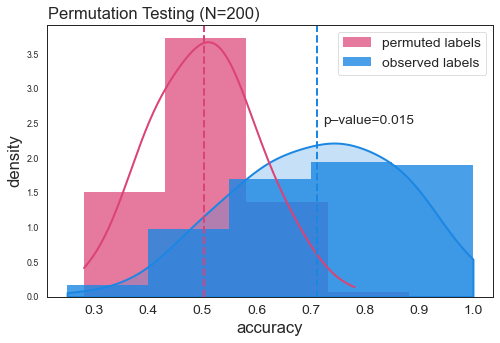

In [289]:

# Now plot permuted scores along with the cross-validated scores

sns.set('paper','white')
_, ax = plt.subplots(figsize=(8,5))

# permutation scores
sns.histplot(perm_scores, ax=ax, color=(.86, .26, .46), lw=0, binwidth=.15, stat='density', label='permuted labels',alpha=.7)
sns.kdeplot(perm_scores, ax=ax, color=(.86, .26, .46), lw=2, cut=0, bw_method=.5)
ax.axvline(perm_scores.mean(), color=(.86, .26, .46), ls='--', lw=2)

# observation scores
sns.histplot(cv_scores, ax=ax, color=(.11, .53, .89), lw=0, binwidth=.15, stat='density',  label='observed labels', alpha=.8)
g = sns.kdeplot(cv_scores, ax=ax, color=(.11, .53, .89), lw=2, fill=True, cut=0, bw_method=.5)
ax.axvline(cv_scores.mean(), color=(.11, .53, .89), ls='--', lw=2)

# tweaks
plt.xlabel('accuracy', fontsize='xx-large')
plt.ylabel('density', fontsize='xx-large')
plt.xticks(fontsize='x-large')

plt.suptitle(f'Permutation Testing (N={len(perm_scores)})', x = .31, y=.93, fontsize='xx-large')
plt.legend(loc='upper right', fontsize='x-large')

plt.text(cv_scores.mean() + .01,  2.5, f'p–value={pvalue:.3f}', fontsize='x-large')

plt.show()

In [ ]:
# FEATURE IMPORTANCE (SHUFFLE X)

from sklearn.inspection import permutation_importance
from tqdm.auto import tqdm

cv = StratifiedShuffleSplit(n_splits=100, test_size=8)

model: Pipeline = grid.best_estimator_  # type: ignore

model.set_params(connectivity__kind='tangent')

X_conn = model[:2].transform(X)
feature_names = model[:2].get_feature_names_out()

importances = []

for train, test in tqdm(cv.split(X,y), total=cv.get_n_splits(X,y)):
    model.fit(X[train], y[train])

    results = permutation_importance(model[2:], X_conn[test], y[test],
                                     scoring=grid.scoring,
                                     n_jobs=1)
    importances.append(results.importances.T)


importances = pd.DataFrame(np.vstack(importances), columns=feature_names)


# sort by mean importance
sorted_columns = importances.mean(axis=0).sort_values(ascending=False).index
perm_imp_scores = importances[sorted_columns]


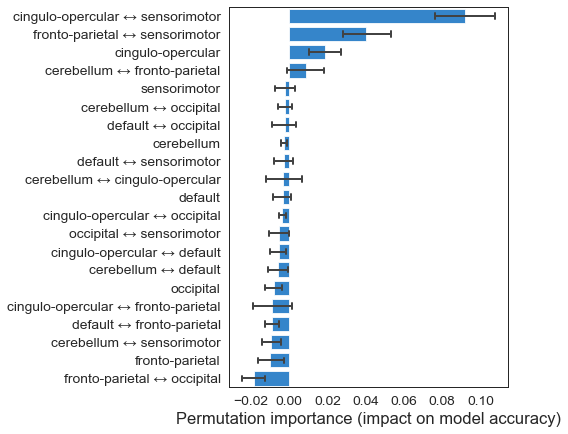

In [141]:

_, ax = plt.subplots(1,1,figsize=(5,7))
sns.barplot(data=perm_imp_scores,
            orient='horizontal',
            capsize=.3,
            errwidth=2,
            color=(.11, .53, .89),
            ax=ax)

plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Permutation importance (impact on model accuracy)', fontsize='xx-large')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

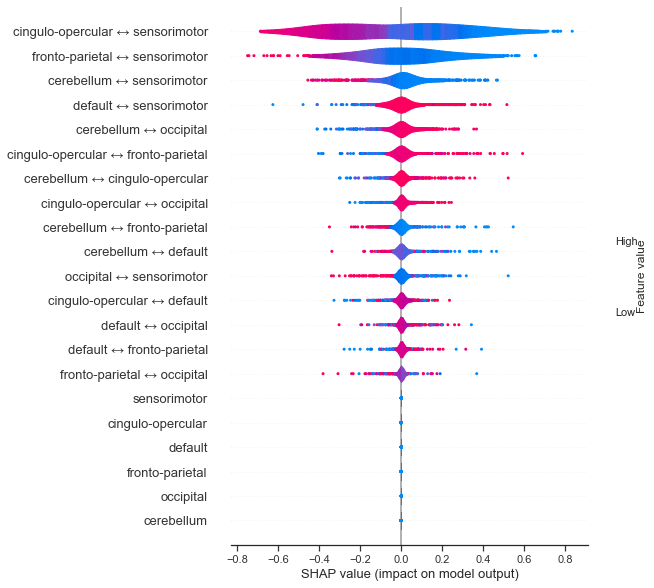

In [46]:
# SHAP

import shap
from tqdm.auto import tqdm

shap_values_cv = []
test_indices = []
y_test_cv = []
y_pred_cv = []

feature_names = grid.best_estimator_[:2].get_feature_names_out()

cv = StratifiedShuffleSplit(n_splits=100, test_size=8)

n_splits = cv.get_n_splits(X, y)

X_conn = grid.best_estimator_[:2].fit_transform(X, y)

for train, test in tqdm(cv.split(X, y), total=n_splits):

    shap_model = grid.best_estimator_[2:].fit(X_conn[train], y[train])

    y_pred = shap_model.predict(X_conn[test])

    test_indices.extend(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

    explainer = shap.Explainer(
        shap_model.predict, X_conn[train],
        feature_names=feature_names,
        # approximate=True,
        # model_output='raw',
        # feature_perturbation='interventional',
    )

    shap_values = explainer(X_conn[test])#, check_additivity=True)

    shap_values_cv.append(shap_values)

# merge CV SHAPs

X = subjects.reshape(-1, 1)
X_test = pd.DataFrame(X[np.hstack(test_indices)], columns=['subject'])
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

shap.summary_plot(shap_values, max_display=21, show=True, plot_type='violin')


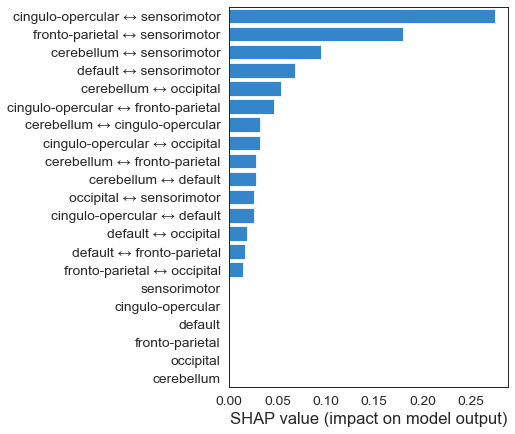

In [157]:
shap_importances = pd.DataFrame({
    'shap': np.abs(shap_values.values).mean(axis=0),
    'feature_name': feature_names
}).sort_values('shap')


_, ax = plt.subplots(1,1,figsize=(5,7))
sns.barplot(data=shap_importances[::-1],
            x='shap',
            y='feature_name',
            orient='horizontal',
            capsize=.3,
            errwidth=2,
            color=(.11, .53, .89),
            ax=ax)

plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.ylabel('')
plt.xlabel('SHAP value (impact on model output)', fontsize='xx-large')
plt.show()

FixedFormatter should only be used together with FixedLocator


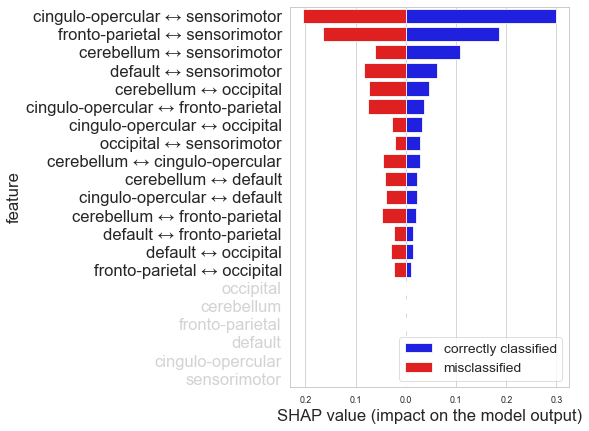

In [276]:
# DIAGNOSIS OF MISCLASSIFICATION

incorrect_pred_mask = np.where(y_pred != y_test)[0]     # miss classified
correct_pred_mask = np.where(y_pred == y_test)[0]     # correctly classified

sns.set('paper', 'whitegrid')

# DBEUG
# shap.summary_plot(shap_values.values[misclassified_mask],
#                   plot_type='bar', feature_names=feature_names)

missclassified_shaps = np.abs(shap_values.values[incorrect_pred_mask]).mean(axis=0)

plot_data = pd.DataFrame({
    'incorrect_shap': np.abs(shap_values.values[incorrect_pred_mask]).mean(axis=0),
    'correct_shap': np.abs(shap_values.values[correct_pred_mask]).mean(axis=0),
    'feature_name': feature_names
})

plot_data = plot_data.sort_values('correct_shap', ascending=False)
plot_data['incorrect_shap'] = -plot_data['incorrect_shap']

_, ax = plt.subplots(1,1,figsize=(5,7))

sns.barplot(data=plot_data, x='correct_shap', y='feature_name', color='blue', ax=ax, label='correctly classified')
sns.barplot(data=plot_data, x='incorrect_shap', y='feature_name', color='red', ax=ax, label='misclassified')

# ax.text(.05, 7.5, 'Correctly\nClassified', color='blue', fontsize='x-large', ha='left')
# ax.text(-.05, 7, 'Misclassified', color='red', fontsize='x-large', ha='right')

plt.yticks(fontsize='xx-large')
plt.legend(fontsize='x-large', loc='lower right')

for tick in ax.get_yticklabels():
    if '\N{left right arrow}' not in str(tick):
        tick.set_color('lightgray')

ax.set_xticklabels([np.round(np.abs(t), 2) for t in ax.get_xticks()])

ax.set_xlabel('SHAP value (impact on the model output)', fontsize='xx-large')
ax.set_ylabel('feature', fontsize='xx-large')

# plt.suptitle(f'SHAP values for {n_samples} correctly classified subjects sampled from all the cross-validation validation splits.\n', ha='left', x=-.3, y=.9, fontsize=14)
plt.show()

## Appendix

In [47]:
# LEARNING CURVE ANALYSIS

from sklearn.model_selection import learning_curve
import pandas as pd

train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y,
                                                        cv=StratifiedShuffleSplit(n_splits=10, test_size=8),
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        shuffle=True,
                                                        train_sizes=np.array([16, 18, 20, 22, 24]))


learning_curve_results = pd.DataFrame({
    'train_size': train_sizes,
    'mean_train_score': train_scores.mean(axis=1),
    'mean_test_score': test_scores.mean(axis=1)
})

learning_curve_results

,train_size,mean_train_score,mean_test_score
0,16,1.0,0.6000
1,18,1.0,0.6250
2,20,1.0,0.6500
3,22,1.0,0.6875
4,24,1.0,0.6875
